# Liouvillian of one cavity and $N$ spins, open Dicke model

We consider a system of $N$ two-level systems (TLSs) coupled to a cavity mode, such that it can emit and absorb two photons at a time. This is known as the two-photon Dicke model.



\begin{eqnarray}
H&=&\frac{\omega_{0}}{N}J_z +  \omega_{c}a^\dagger a + g\left((a^\dagger)^2 + (a)^2\right)\left(J_{+} + J_{-}\right)
\end{eqnarray}

and it is an extension to $N>1$ of the two-photon Rabi model [1-4]. Note the normalization in $N$ of the atomic bare energy term. 


Each TLS has identical frequency $\omega_{0}$. The light matter coupling can be in the ultrastrong coupling (USC) regime, $g/omega_{0}>0.1$.

If we study this model as an open quantum system, the cavity can leak photons and the TLSs are subject to local processes. For example the system can be incoherently pumped at a rate $\gamma_\text{P}$, the TLSs are subject to dephaisng at a rate $\gamma_\text{D}$, and local incoherent emission occurs at a rate $\gamma_\text{E}$. The dynamics of the coupled light-matter system is governed by

\begin{eqnarray}\dot{\rho} &=& 
-i\lbrack H,\rho \rbrack
+\frac{\kappa}{2}\mathcal{L}_{a}[\rho]
+\frac{\gamma_\text{CE}}{2}\mathcal{L}_{J_{-}}[\rho] 
+\sum_{n=1}^{N}\left(\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho] 
+\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{+,n}}[\rho]
+\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{+,n}}[\rho]\right)
\end{eqnarray}

When only the dissipation of the cavity is present, beyond a critical value of the coupling $g$, the steady state of the system becomes superradiant. This is visible by looking at the Wigner function of the photonic part of the density matrix, which displays two displaced lobes in the $x$ and $p$ plane.   

As it has been shown in Ref. [5], the presence of dephasing suppresses the superradiant phase transition, while the presence of local emission restores it [6].

In order to study this system using QuTiP [7] and $PIQS$ [8], we will first build the TLS Liouvillian, then we will build the photonic Liouvillian and finally we will build the light-matter interaction. The total dynamics of the system is thus defined in a Liouvillian space that has both TLS and photonic degrees of freedom. 

## 1) Piqs method

In [1]:
from time import clock
import matplotlib.pyplot as plt
from scipy.io import mmwrite
import matplotlib as mpl
from matplotlib import cm

from qutip import *
from qutip.piqs import *

In [2]:
#spin parameters
N = 3
ntls = N
system = Dicke(N = ntls)
nds = num_dicke_states(ntls)
[jx, jy, jz] = jspin(N)
jp = jspin(N, "+")
jm = jspin(N, "-")
w0 = 0.1 # bare frequency
wx = 0. # coherent driving
system.hamiltonian = w0 * jz + wx * jx 

gE = 0.001
gCE = 0.0
system.collective_emission = gCE
system.emission = gE

liouv = system.liouvillian() 
#photon parameters
wc = 1.
nphot = 2*N+3
kappa = 0.01
pump = 0.
a = destroy(nphot)
c_ops_phot = [np.sqrt(kappa) * a, np.sqrt(pump) * a.dag()]
liouv_phot = liouvillian(wc * a.dag()*a , c_ops_phot)
#spin-photon parameters
#w_int = 1.6/np.sqrt(ntls)
w_int = wc*.8
g = w_int
gc = wc/2.0#wc/(4*ntls)
gt = np.sqrt(wc*w0*N/4)
print('gt/gc',gt/gc)
print('g/gc', g/gc)
print('g/gt', g/gt)
print("g ",g)
Dicke_true = True
jc_true = False
if Dicke_true == True:
    h_int = w_int * tensor((a + a.dag()), jx) # standard Dicke Hamiltonian
    print("1-phot Dicke model for hint")
if jc_true == True:
    h_int = w_int * (tensor(a, jp)+tensor(a.dag(), jm)) # standard JC Hamiltonian
    print("1-phot Jaynes-Cummings model for hint")

gt/gc 0.5477225575051662
g/gc 1.6
g/gt 2.9211869733608857
g  0.8
1-phot Dicke model for hint


In [3]:
print(4**N,num_dicke_states(N),N**3,N**4)

64 6 27 81


In [4]:
#identity super-operators
id_tls = to_super(qeye(nds))
id_phot =to_super(qeye(nphot))
#total liouvillian
liouv_tot = super_tensor(liouv_phot, id_tls) + super_tensor(id_phot, liouv)
#strong coupling light-matter interaction
liouv_h_int = -1j* spre(h_int) + 1j* spost(h_int)
liouv_tot_int = liouv_tot + liouv_h_int
print(liouv_tot_int.shape)

(2916, 2916)


In [5]:
#solve using qutip
jz_tot = tensor(qeye(nphot), jz)
jpjm_tot = tensor(qeye(nphot), jp*jm)
jm_tot = tensor(qeye(nphot), jm)
jp_tot = tensor(qeye(nphot), jp)
adag_tot = tensor(a.dag(), qeye(nds))
a_tot = tensor(a, qeye(nds))
adag_a_tot = tensor(a.dag()*a, qeye(nds))
adag2_a2_tot = tensor(a.dag()**2*a**2, qeye(nds))

In [6]:
clock_t0 = clock()
rho_ss = steadystate(liouv_tot_int,method='direct')
#steadystate 'method': direct,eigen,power,iterative-gmres,iterative-lgmres,svd

clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("steadystate time ",dt_clock)
jzt_ss = expect(jz_tot, rho_ss)
jpjmt_ss = expect(jpjm_tot, rho_ss)
adagat_ss = expect(adag_a_tot, rho_ss)
rhoss_phot = Qobj(rho_ss[:nphot,:nphot])
rhoss_spin = Qobj(rho_ss[-rho_ss.shape[0]:,-rho_ss.shape[0]:])
rhoss_phot1 = rho_ss.ptrace(0)
rhoss_spin1 = rho_ss.ptrace(1)
adagat_ss

steadystate time  0.06966300000000003


/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


0.8152236523395088

## Eigenvalues of the Liouvillian

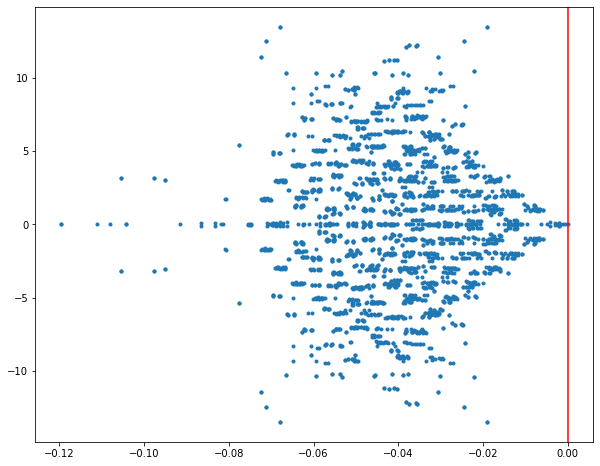

In [7]:
eigs, eigv = liouv_tot_int.eigenstates()
re_eigs = np.real(eigs)
im_eigs = np.imag(eigs)
plt.figure(figsize=(10,8))
plt.plot(re_eigs,im_eigs,'.')
plt.axvline(x=0,color="red")
#plt.xlim([-1,0.1])
plt.show()
plt.close()

The spectrum of the Liouvillian shows the eigenvalues $\lambda$ in the complex plane. 
All Liouvillians have a symmetry around the horizontal axis and take only real negative values, $\text{Re}[\lambda]<0$ (left of the red line). 

## Wigner function of the steady state $\rho_\text{ss}$

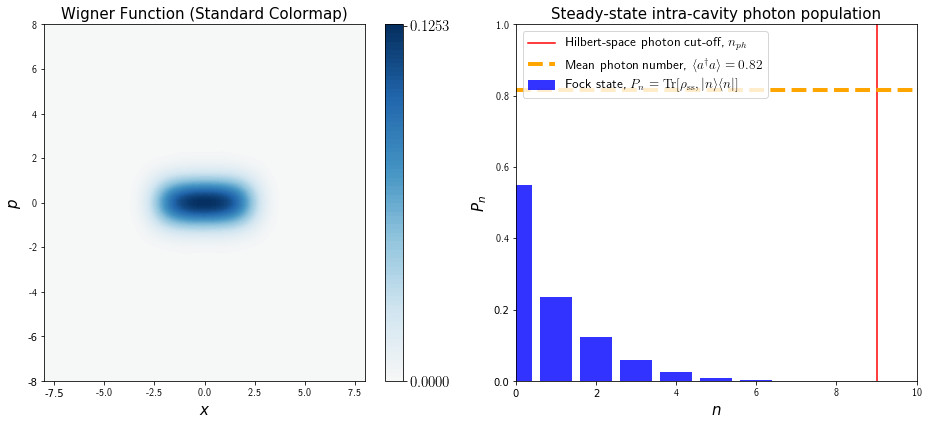

In [8]:
#psi = (basis(10, 0) + basis(10, 3) + basis(10, 9)).unit()
psi = rho_ss.ptrace(0)
xvec = np.linspace(-8, 8, 100)
W = wigner(psi, xvec, xvec)
wmap = wigner_cmap(W)  # Generate Wigner colormap
nrm = mpl.colors.Normalize(-W.max(), W.max())

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
label_size = 15
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
# first subplot
plt1 = axes[0].contourf(xvec, xvec, W, 100, cmap=cm.RdBu, norm=nrm)
axes[0].set_title(r"Wigner Function (Standard Colormap)", fontsize=label_size);
max_cb =np.max(W)
min_cb =np.min(W)
cb1 = fig.colorbar(plt1, ax=axes[0],ticks=[min_cb, max_cb])
# Wigner colormap option
wigner_map = False
if wigner_map == True:
    plt2 = axes[0].contourf(xvec, xvec, W, 100, cmap=wmap)  
    cb2 = fig.colorbar(plt2, ax=axes[1], ticks=[0, max_cb])
    axes[0].set_title(r"Wigner Function (Wigner Colormap)", fontsize=label_size);
axes[0].set_xlabel(r"$x$", fontsize=label_size)
axes[0].set_ylabel(r"$p$", fontsize=label_size)

# plot its fock-state distribution
# second subplot
axes[1].set_title(r"Steady-state intra-cavity photon population", fontsize=label_size);
axes[1].bar(np.arange(0, nphot), 
            np.real(psi.diag()), color="blue", 
            alpha=0.8,
            label =r"Fock state, $P_{n}=\mathrm{Tr}[\rho_\mathrm{ss},|n\rangle \langle n |]$")
axes[1].axvline(x=nphot,color="red",
                label =r"Hilbert-space photon cut-off, $n_{ph}$")
nph_ss=(psi*(a.dag()*a)).tr()
axes[1].axhline(y=nph_ss,
                linestyle='dashed',
                color="orange",
                linewidth = 4,
                label =r"Mean photon number, $\langle a^\dagger a \rangle={}$".format(np.round(nph_ss,2)))
axes[1].set_ylim(0, 1)
nmaxphot_bar = nphot+1
axes[1].set_xlim(0, nmaxphot_bar)
axes[1].set_xlabel(r"$n$", fontsize=label_size)
axes[1].set_ylabel(r"$P_n$", fontsize=label_size)
# saving plot options
fig.tight_layout()
fname = 'cs_wigner_2phot_N{}.pdf'.format(N)
plt.legend(fontsize=label_size*0.9,loc=2)
savefile = False
if savefile == True:
    plt.savefig(fname, bbox_inches='tight')
plt.show()
plt.close()

 ## Steady-state correlations: $g^{(2)}(\tau)$ for $\rho_\text{ss}$

In [9]:
# time integration parameters
nt = 1001
tmax = 400 
t = np.linspace(0, tmax, nt)

B = adag_a_tot
rhoB = a_tot * rho_ss * adag_tot

clock_t0 = clock()
opts = Options(store_states = True, nsteps = 1000, atol = 1e-6)
result3 = mesolve(liouv_tot_int, rhoB, t, [], e_ops = B, options = opts)
nt_bos = result3.states
g2t_bos = result3.expect[0]
clock_tf = clock()
dt_clock = clock_tf - clock_t0
print("integration time (s): ",dt_clock)

g2_norm, G2 = coherence_function_g2(liouv_tot_int, None, t, [], a_tot)

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


integration time (s):  2.420608999999999


## Time evolution

In [10]:
# initial tensor state
excited_ = dicke(N, N/2, N/2)
ground_ = dicke(N, N/2, -N/2)
rho0_tls = ground_
ground_phot = ket2dm(basis(nphot, 0))
rho0 = tensor(ground_phot, rho0_tls)
# solution of the master equation
opts = Options(store_states = True, nsteps = 10000, atol = 1e-6)
result4 = mesolve(liouv_tot_int, rho0, t, [], e_ops = [jz_tot, adag_a_tot, jpjm_tot], options = opts)
rhot_tot = result4.states
jzt_tot = result4.expect[0]
adagat_tot = result4.expect[1]
jpjmt_tot = result4.expect[2]

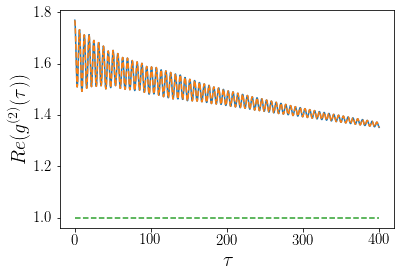

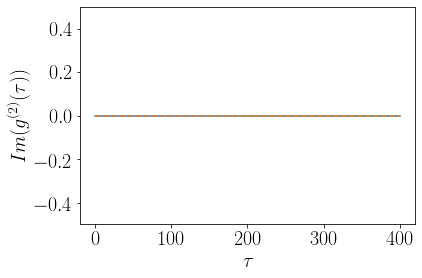

In [11]:
jmax = (0.5 * N)
j2max = (0.5 * N + 1) * (0.5 * N)

plt.rc('text', usetex = True)
label_size = 20
label_size2 = 20
label_size3 = 20

fig1 = plt.figure()
plt.plot(t, np.real(g2t_bos)/adagat_ss**2, '-', label = 'g2 nat')
plt.plot(t, np.real(g2_norm), '--', label = 'g2 qutip')
plt.plot(t, 0 * t + 1, '--', label = '')
#plt.ylim([-1,1])
plt.xlabel(r'$\tau$', fontsize = label_size3)
plt.ylabel(r'$Re(g^{(2)}(\tau))$', fontsize = label_size3)
#plt.xticks([0,(tmax/2)/td0,tmax/td0])
#plt.yticks([0.85,1])
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)
fname = 'sssr_g2t_N{}.pdf'.format(N)
plt.savefig(fname, bbox_inches='tight')    
plt.show()
plt.close()
# Imag(g2) should be zero
plt.figure()
plt.plot(t, np.imag(g2t_bos))
plt.plot(t, np.imag(g2_norm), '--')
plt.xlabel(r'$\tau$', fontsize = label_size3)
plt.ylabel(r'$Im(g^{(2)}(\tau))$', fontsize = label_size3)
plt.ylim([-0.5, 0.5])
plt.show()
plt.close()

The imaginary part of the $g^{(2)}(\tau)$ should be always zero. The real part quantifies the photon statistics, such as bunching and anti-bunching in the system. 

## 3) Plots -- Operators time evolutions

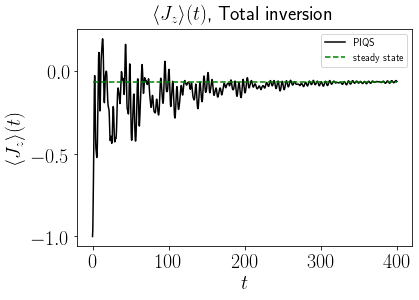

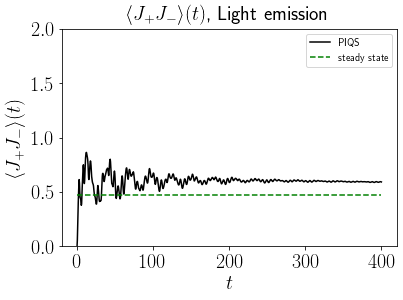

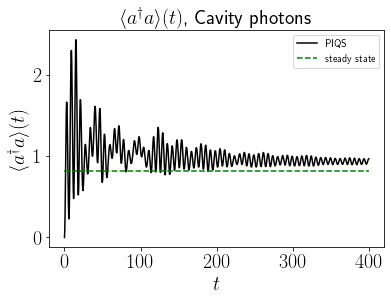

In [12]:
jmax = (N/2)
j2max = N/2*(N/2+1)

label_size = 20
label_size3 = 20

fig1 = plt.figure(1)
plt.rc('text', usetex = True)
plt.plot(t, jzt_tot/jmax, 'k-', label='PIQS')
plt.plot(t, t*0+jzt_ss/jmax, 'g--', label = 'steady state')
#plt.ylim([-1,-1+0.3])
plt.title(r'$\langle J_{z}\rangle(t)$, Total inversion', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size3)
plt.ylabel(r'$\langle J_{z}\rangle(t)$', fontsize = label_size3)
plt.legend()
plt.show()
plt.close()

fig2 = plt.figure(2)
plt.plot(t, jpjmt_tot/j2max, 'k-', label='PIQS')
plt.plot(t, t*0+jpjmt_ss/j2max, 'g--', label = 'steady state')
plt.ylim([0,2])
plt.title(r'$\langle J_{+}J_{-}\rangle(t)$, Light emission', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size3)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle(t)$', fontsize = label_size3)
plt.legend()
plt.show()
plt.close()

fig3 = plt.figure(3)
plt.plot(t, adagat_tot, 'k-', label='PIQS')
plt.plot(t, t*0 + adagat_ss, 'g--', label = 'steady state')
#plt.ylim([0, 2*np.max(adagat_tot)])
plt.title(r'$\langle a^\dagger a\rangle(t)$, Cavity photons', fontsize = label_size)
plt.xlabel(r'$t$', fontsize = label_size3)
plt.ylabel(r'$\langle a^\dagger a\rangle(t)$', fontsize = label_size3)

plt.legend()
plt.show()
plt.close()

In [13]:
# Here we study the time evolution of the Wigner function and of the photons in the Fock state basis 
## Sampling Time integrations
nt_sample = 10
tlist = np.linspace(0, tmax/1, nt_sample) 
result5 = mesolve(liouv_tot_int, rho0, tlist, [], options = opts)
rhot_tot = result5.states
rhocav_list=[]


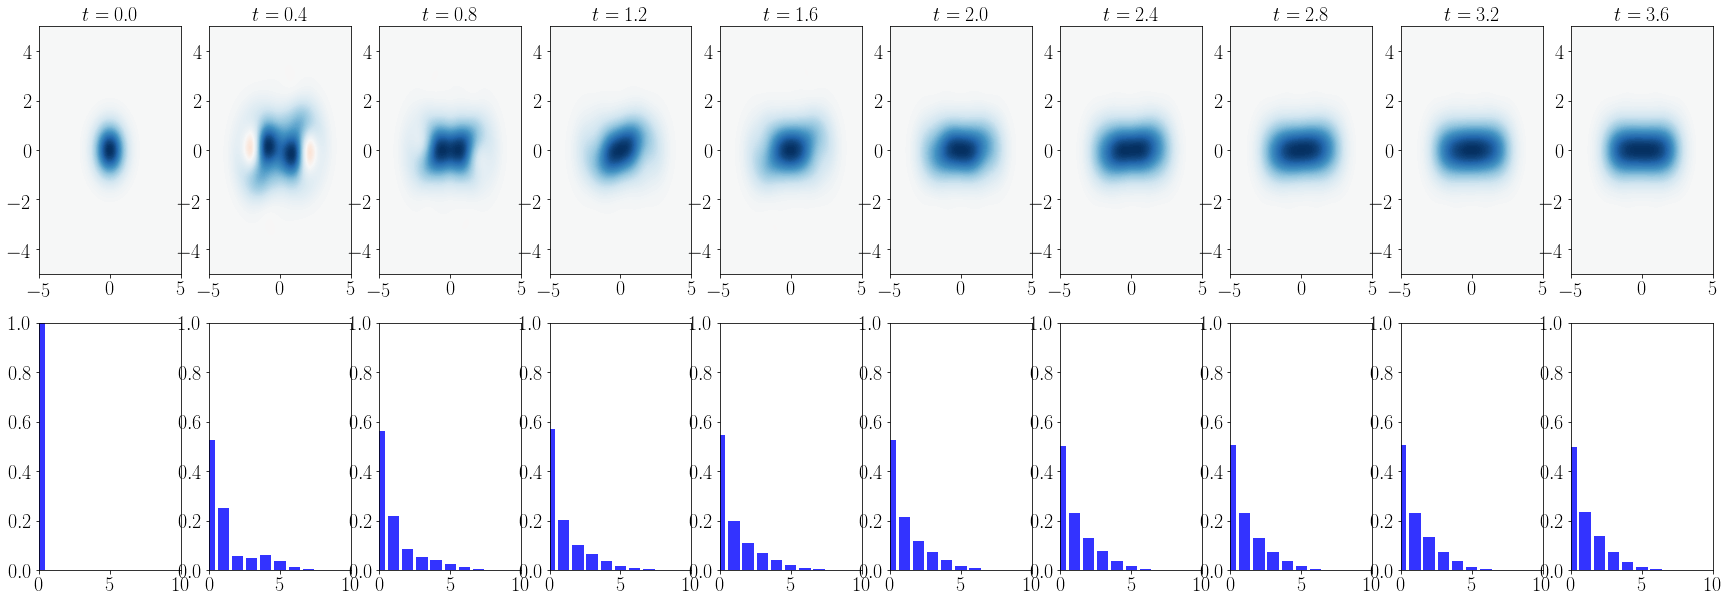

In [14]:

xvec = np.linspace(-5,5,200)
fig, axes = plt.subplots(2, len(rhot_tot),
                         figsize=(3*len(rhot_tot), nt_sample))
for idx, rhot in enumerate(rhot_tot):
    # trace out the cavity density matrix
    rhot_cavity = ptrace(rhot, 0)
    rhocav_list.append(np.real(rhot_cavity.full()))
    # calculate its wigner function
    W = wigner(rhot_cavity, xvec, xvec,method='laguerre')
    # Wigner method:‘iterative’, ‘laguerre’, ‘fft’
    # plot its wigner function
    wlim = abs(W).max()
    axes[0,idx].contourf(xvec, xvec, W, 100, 
                         norm=mpl.colors.Normalize(-wlim,wlim), 
                         cmap=plt.get_cmap('RdBu'))
    axes[0,idx].set_title(r'$t = %.1f$' % t[idx], fontsize=label_size) 
    # plot its fock-state distribution
    axes[1,idx].bar(np.arange(0, nphot), 
                    np.real(rhot_cavity.diag()), color="blue", alpha=0.8)
    axes[1,idx].set_ylim(0, 1)
    nmaxphot_bar = 10
    axes[1,idx].set_xlim(0, nmaxphot_bar)
plt.show()
plt.close()

In [15]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.1
Numpy Version:      1.15.4
Scipy Version:      1.2.1
Cython Version:     0.29.8
Matplotlib Version: 3.1.0
Python Version:     3.7.3
Number of CPUs:     2
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.cite()`


### References

[1] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, https://arxiv.org/abs/1805.05129

[2] P. Kirton and J. Keeling, *Phys. Rev. Lett.* **118**, 123602 (2017)

[3] E.G. Dalla Torre *et al.*, *Phys Rev. A* **94**, 061802(R) (2016)

[4] J. R. Johansson, P. D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012) http://qutip.org